# Imports

In [1]:
from sinenn import build_sin_model
from maen_score import maen_score

import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
def least_squares(x: np.array, y: np.array):
    """
    returns a, b for y = ax + b given x and y values
    """
    n = len(x)
    sum_x = np.sum(x)
    sum_y = np.sum(y)
    sum_x2 = np.sum(x**2)
    sum_xy = np.sum(x * y)
    a = (n * sum_xy - sum_x * sum_y) / (n * sum_x2 - sum_x**2)
    b = (sum_y * sum_x2 - sum_x * sum_xy) / (n * sum_x2 - sum_x**2)
    return a, b


def sinenn_weights(model):
    return [
        f'{layer}: {weight:.4f}' for layer, weight in
        zip(
            [i.path.replace('/kernel', '') for i in model.weights],
            [i[0][0] for i in model.get_weights()]
        )
    ]

# Sin-wave Generation

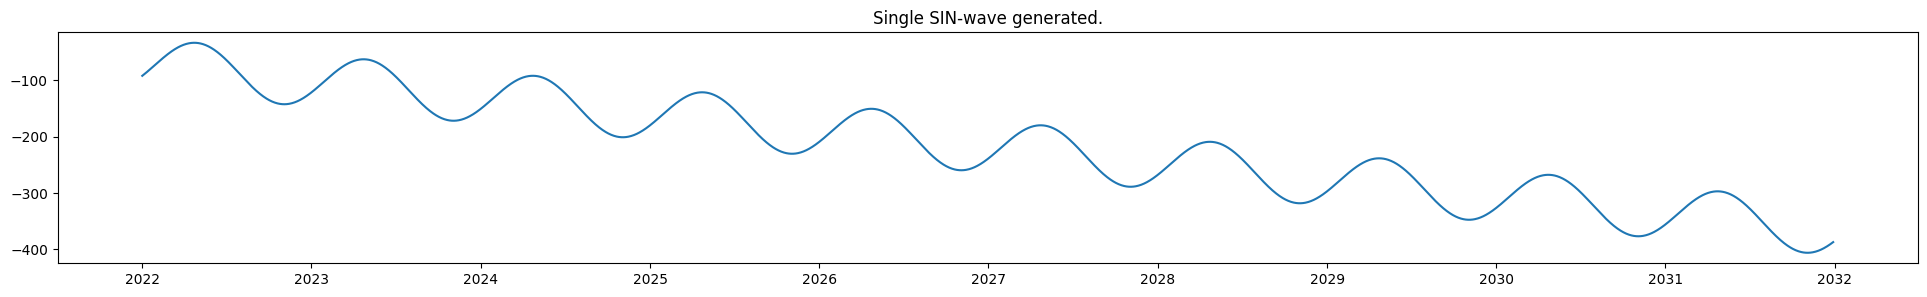

In [3]:
n_years = np.random.randint(1, 15)
frequency = 2 * np.pi / 365.25

beta = 1
elevation_power = 0
amplitude_change_power = 0
variation = True

amplitude = np.random.randint(-100, 100)
phase_shift = np.random.randint(-180, 180)
period_starts = pd.Timestamp('2022-01-01')
a = np.random.randint(-500, 500) / (n_years * 365.25)
b = np.random.randint(-100, 100)

duration_days = 365 * n_years
period_ends = period_starts + pd.Timedelta(days=duration_days)

X = np.linspace(1, duration_days, duration_days)

if not variation:
    y = amplitude * np.sin(frequency * X + phase_shift)
else:
    y = amplitude * (X**amplitude_change_power) * np.sin(X**beta * frequency + phase_shift)

y += a * X + b
y += -1 + X**elevation_power
x_date = pd.date_range(period_starts, period_ends, freq='D')[:-1]

plt.figure(figsize=(24,3))
plt.plot(x_date, y)
plt.title('Single SIN-wave generated.')
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1,1), y, shuffle=False)

# The SIN-based model

In [4]:
import logging
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Add


class SineNN:
  """
  Sin-wave model with linear component\n\n

  example_trainability_map = {\n
    'linear_rotation': True,\n
    'linear_rotation_handler': True,\n
    'y_shift': True,\n
    'y_shift_amplifier': True,\n
    'frequency': False,\n
    'phase_shift': True,\n
    'phase_shift_amplifier': True,\n
    'sin': False,\n
    'amplitude': True,\n
    'output': False\n
  }
  """
  def auto_init(self):
    if any(
      [
        self.init_linear_rotation == 'auto',
        self.init_y_shift == 'auto'
      ]
    ):
      gradient, y_intercept = least_squares(
        self.x.flatten(), self.y
      )
    if self.init_x_shift == 'auto':
      self.init_x_shift = 1,
    if self.init_y_shift == 'auto':
      self.init_y_shift = y_intercept,
    if self.init_linear_rotation == 'auto':
      self.init_linear_rotation = gradient,
    if self.init_frequency == 'auto':
      self.init_frequency = 2 * np.pi / self.wavelen
    if self.init_amplitude == 'auto':
      self.init_amplitude = (self.y.max() - self.y.min()) / 2
    if self.model_name is None:
      self.model_name = 'SineNN'
    if not self.trainability_map:
      self.trainability_map = self.default_trainability_map

  
  def build_wave(self, wave):
    input_layer = Input(
      name=f'input_{self.wave_count}',
      shape=[self.x.shape[1]]
    )

    frequency_layer = tf.keras.layers.Dense(
        1,
        name=f'frequency_{self.wave_count}',
        kernel_initializer=tf.keras.initializers.\
            Constant(value=self.init_frequency / wave),
        use_bias=False
    )(input_layer)

    phase_shift_layer = tf.keras.layers.Dense(
        1,
        name=f'phase_shift_{self.wave_count}',
        activation= lambda x: 0 * x + self.init_x_shift,
        use_bias=False,
        kernel_initializer=tf.keras.initializers.\
            Constant(value=self.init_x_shift)
    )(input_layer)

    phase_shift_amplifier_layer = tf.keras.layers.Dense(
        1,
        name=f'phase_shift_amplifier_{self.wave_count}',
        use_bias=False,
        kernel_initializer=tf.keras.initializers.\
            Constant(value=1)
    )(phase_shift_layer)

    sin_input_layer = tf.keras.layers.Add(name='sin_input')(
        [
            frequency_layer,
            phase_shift_amplifier_layer
        ]
    )

    sin_layer = tf.keras.layers.Dense(
        1,
        name=f'sin_{self.wave_count}',
        activation=lambda sin_input: tf.math.sin(sin_input),
        kernel_initializer=tf.keras.initializers.\
            Constant(value=1),
        use_bias=False
    )(sin_input_layer)

    sin_amplitude_layer = tf.keras.layers.Dense(
        1,
        name=f'amplitude_{self.wave_count}',
        kernel_initializer=tf.keras.initializers.\
            Constant(value=self.init_amplitude),
        use_bias=False
    )(sin_layer)  

    wave_model = tf.keras.models.Model(
        inputs=input_layer,
        outputs=sin_amplitude_layer,
        name=f'Wave_{self.wave_count}'
    )
    if self.wave_components_trainable:
      for layer_name in self.wave_components:
        trainability = self.trainability_map[layer_name]
        layer_name = f'{layer_name}_{self.wave_count}'        
        wave_model.get_layer(name=layer_name).trainable = trainability
    else:
      for layer_name in self.wave_components:
        layer_name = f'{layer_name}_{self.wave_count}'
        wave_model.get_layer(name=layer_name).trainable = False
    return wave_model

  
  def build_trend(self):
    input_layer = tf.keras.layers.Input(
      name='input',
      shape=[self.x.shape[1]]
    )
    linear_rotation_layer = tf.keras.layers.Dense(
      1,
      name='linear_rotation',
      kernel_initializer=tf.keras.initializers.\
        Constant(value=self.init_linear_rotation),
      use_bias=False
    )(input_layer)

    linear_rotation_handler_layer = tf.keras.layers.Dense(
      1,
      name='linear_rotation_handler',
      kernel_initializer=tf.keras.initializers.\
        Constant(value=1),
      use_bias=False
    )(linear_rotation_layer)

    y_shift_layer = tf.keras.layers.Dense(
      1,
      name='y_shift',
      activation= lambda x: 0 * x + self.init_y_shift,
      use_bias=False,
      kernel_initializer=tf.keras.initializers.\
        Constant(value=self.init_y_shift)
    )(input_layer)

    y_shift_amplifier_layer = tf.keras.layers.Dense(
      1,
      name='y_shift_amplifier',
      kernel_initializer=tf.keras.initializers.\
        Constant(value=1),
      use_bias=False,
    )(y_shift_layer)

    linear_component_layer = tf.keras.layers.Add(name='linear_component')(
      [
        linear_rotation_handler_layer,
        y_shift_amplifier_layer
      ]
    )
    linear_model = tf.keras.models.Model(
        inputs=input_layer,
        outputs=linear_component_layer,
        name=f'Trend'
    )
    if self.linear_trend_trainable:
      for layer_name in self.linear_components:
        trainability = self.trainability_map[layer_name]
        linear_model.get_layer(name=layer_name).trainable = trainability
    else:
      for layer_name in self.linear_components:
        linear_model.get_layer(name=layer_name).trainable = False
    return linear_model
  

  def build(self):
    self.wave_count = 0
    input_layer = tf.keras.layers.Input(
      name='input',
      shape=[self.x.shape[1]]
    )    

    linear_trend_layer = self.build_trend()(input_layer)
    wave_models = {}
    for wave in self.waves:
      self.wave_count += 1
      wave_models[wave] = self.build_wave(wave)(input_layer)
    waves_layer = tf.keras.layers.Add(name='waves')(list(wave_models.values()))
    output_layer = Add(name='output')(
      [
        linear_trend_layer,
        waves_layer
      ]
    )
    self.model = Model(
      inputs=input_layer,
      outputs=output_layer,
      name=self.model_name
    )    
    adam = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
    self.model.compile(optimizer=adam, loss='mse')
    if self.show_summary:
      self.model.summary()
    return self.model
    

  def __init__(
    self,    
    x, y,
    waves=(1,),
    wavelen=365.25,
    init_x_shift='auto',
    init_y_shift='auto',
    init_linear_rotation='auto',
    init_frequency='auto',
    init_amplitude='auto',
    learning_rate=10**-1,
    linear_trend_trainable=True,
    wave_components_trainable=True,
    trainability_map=None,
    model_name=None,
    show_summary=True
  ) -> None:
    self.x = x
    self.y = y
    self.wavelen = wavelen
    self.waves = waves
    self.init_x_shift = init_x_shift
    self.init_y_shift = init_y_shift
    self.init_linear_rotation = init_linear_rotation 
    self.init_frequency = init_frequency
    self.init_amplitude = init_amplitude
    self.learning_rate = learning_rate
    self.linear_trend_trainable = linear_trend_trainable
    self.wave_components_trainable = wave_components_trainable
    self.trainability_map = trainability_map
    self.model_name = model_name
    self.show_summary = show_summary
    self.default_trainability_map = {
      'linear_rotation': True,
      'linear_rotation_handler': True,
      'y_shift': True,
      'y_shift_amplifier': True,
      'frequency': False,
      'phase_shift': True,
      'phase_shift_amplifier': True,
      'sin': False,
      'amplitude': True,
      'output': False
    }
    self.linear_components = [
      'linear_rotation',
      'linear_rotation_handler',
      'y_shift',
      'y_shift_amplifier'
    ]
    self.wave_components = [
      'frequency',
      'phase_shift',
      'phase_shift_amplifier',
      'sin',
      'amplitude'
    ]
    self.auto_init()
    self.build()
  
  def __call__(self):
    return self.model

In [5]:
sin_model = SineNN(
    X_train,
    y_train,
    learning_rate=0.1,
    linear_trend_trainable=False,
    wave_components_trainable=True,
    waves=[2, 1, 1/2],
    show_summary=True
)()


Model: "SineNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 1)         │       0 │ -                    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ Wave_1 (Functional) │ (None, 1)         │       5 │ input[0][0]          │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ Wave_2 (Functional) │ (None, 1)         │       5 │ input[0][0]          │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ Wave_3 (Functional) │ (None, 1)         │       5 │ input[0][0]          │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ Trend (Functional)  │ (None, 1)         │       4 │ input[0][0]          │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ waves (Add)         │ (None, 1)         │       0 │ Wave_1[0][0],        │
│                     │                   │         │ Wave_2[0][0],        │
│                     │                   │         │ Wave_3[0][0]         │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ output (Add)        │ (None, 1)         │       0 │ Trend[0][0],         │
│                     │                   │         │ waves[0][0]          │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 19 (76.00 B)

 Trainable params: 9 (36.00 B)

 Non-trainable params: 10 (40.00 B)

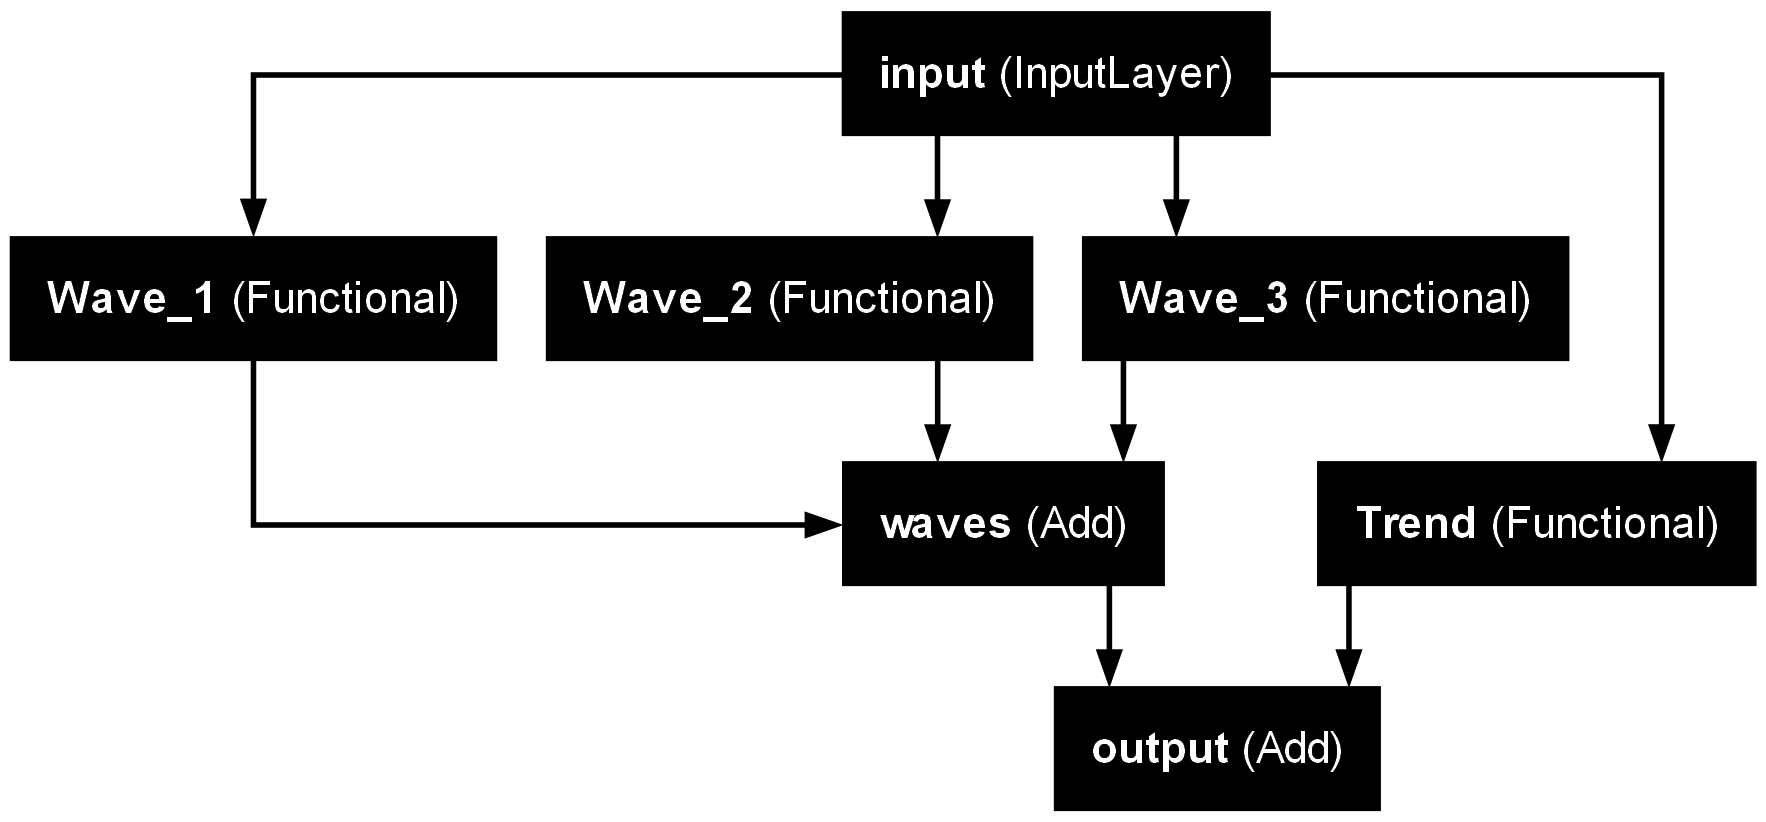

In [6]:
tf.keras.utils.plot_model(sin_model, show_layer_names=True)

In [7]:
sinenn_weights(sin_model)

['phase_shift_1: 1.0000',
 'frequency_1: 0.0086',
 'phase_shift_amplifier_1: 1.0000',
 'sin_1: 1.0000',
 'amplitude_1: 142.4562',
 'phase_shift_2: 1.0000',
 'frequency_2: 0.0172',
 'phase_shift_amplifier_2: 1.0000',
 'sin_2: 1.0000',
 'amplitude_2: 142.4562',
 'phase_shift_3: 1.0000',
 'frequency_3: 0.0344',
 'phase_shift_amplifier_3: 1.0000',
 'sin_3: 1.0000',
 'amplitude_3: 142.4562',
 'linear_rotation: -0.0802',
 'y_shift: -69.3006',
 'linear_rotation_handler: 1.0000',
 'y_shift_amplifier: 1.0000']

# Forecast:  Test on a synthetic example

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


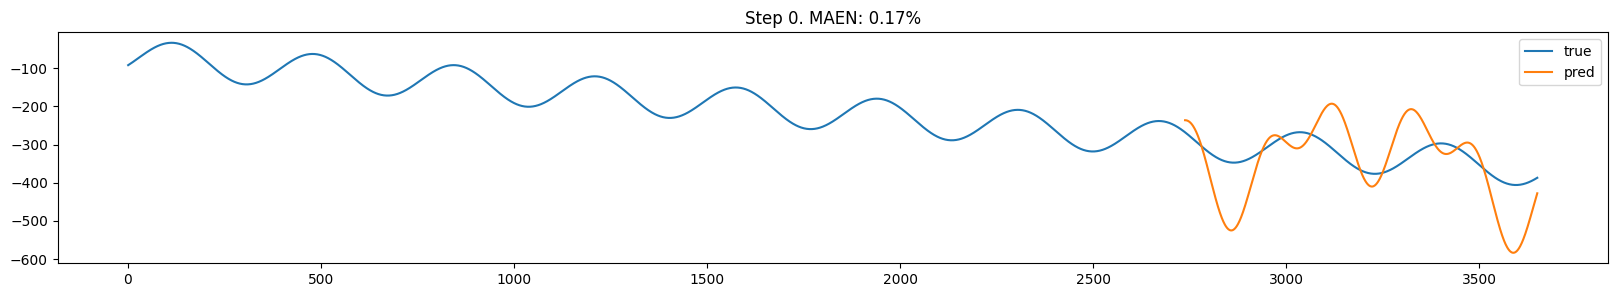

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step


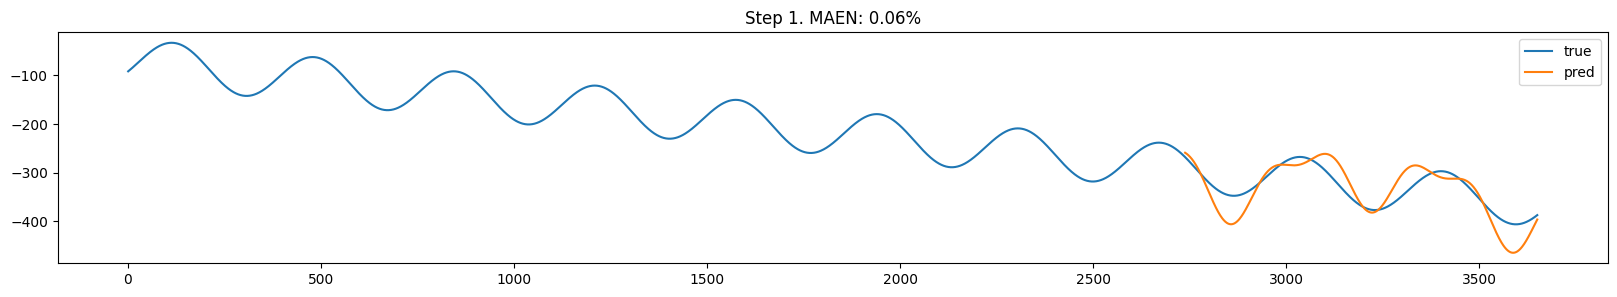

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


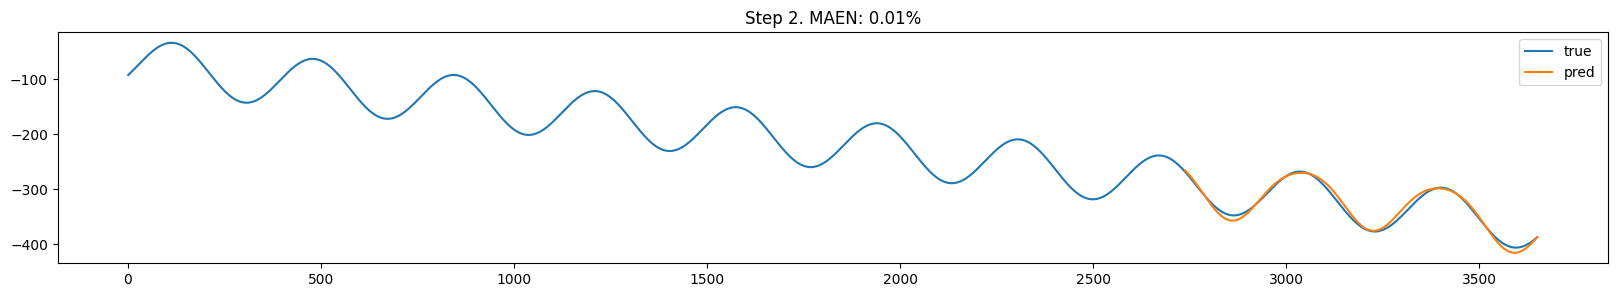

In [8]:
for step in range(3):
  sin_model.fit(
    X_train,
    y_train,
    epochs=10,
    verbose=False
  )
  y_pred = sin_model.predict(X_test).flatten()
  maen =  maen_score(y_test, y_pred, min_=y.min(), max_=y.max())
  fig = plt.figure(figsize=(20, 3))
  plt.plot(X.flatten(), y, label='true')
  plt.plot(X_test.flatten(), y_pred, label='pred')
  plt.title(f'Step {step}. MAEN: {maen:.2f}%')
  plt.legend()
  plt.show()

In [9]:
sinenn_weights(sin_model)

['phase_shift_1: 1.0000',
 'frequency_1: 0.0086',
 'phase_shift_amplifier_1: 5.2205',
 'sin_1: 1.0000',
 'amplitude_1: 5.3431',
 'phase_shift_2: 1.0000',
 'frequency_2: 0.0172',
 'phase_shift_amplifier_2: -0.4683',
 'sin_2: 1.0000',
 'amplitude_2: 48.1970',
 'phase_shift_3: 1.0000',
 'frequency_3: 0.0344',
 'phase_shift_amplifier_3: 0.7481',
 'sin_3: 1.0000',
 'amplitude_3: 4.9616',
 'linear_rotation: -0.0802',
 'y_shift: -69.3006',
 'linear_rotation_handler: 1.0000',
 'y_shift_amplifier: 1.0000']

WFLR

In [10]:
class WeightedFeatureLinearRegressor:
    def __init__(
        self,
        feature_step: float
    ):
        self.feature_step = feature_step        
    
    def fit(self, x, y):
        """
        x: e.g. np.array(45., None, None, 32.5)
        y: e.g. np.array(200.4, None, None, 150.3)
        """
        df_wflr = pd.DataFrame()
        df_wflr['feature'] = x
        df_wflr['target'] = y
        df_wflr['feature'] = df_wflr['feature'] // self.feature_step * self.feature_step
        df_wflr['feature'] = df_wflr['feature'].ffill()
        df_wflr.fillna(0, inplace=True)
        df_wflr = df_wflr\
            .groupby('feature')\
            .mean()\
            .reset_index()
        if len(df_wflr) == 1:
            a = 0
            b = df_wflr.loc[0, 'target']
        else:
            a, b = least_squares(x=df_wflr['feature'], y=df_wflr['target'])
        self.weights = a, b
        return self
    
    def predict(self, x: np.array):
        a, b = self.weights
        return x * a + b

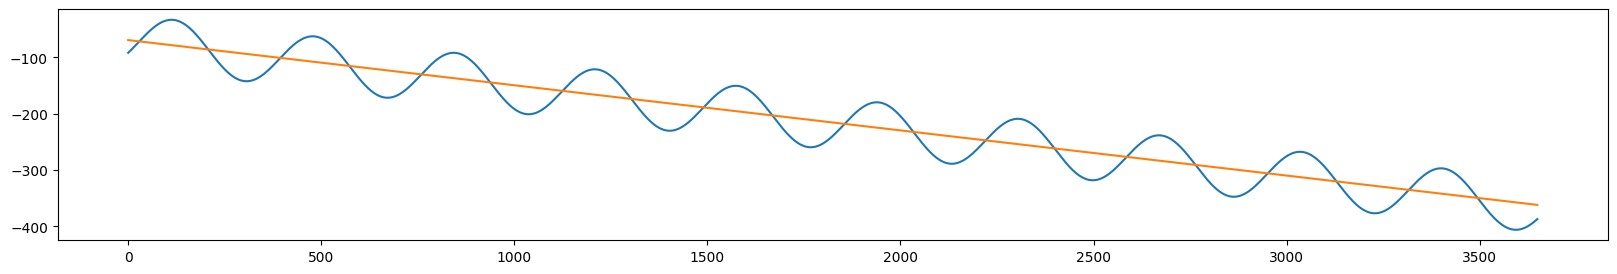

In [11]:
wflr = WeightedFeatureLinearRegressor(feature_step=1)
wflr_pred = wflr.fit(X_train.flatten(), y_train).predict(X.flatten())
plt.figure(figsize=(20, 3))
plt.plot(y)
plt.plot(wflr_pred)